
## Table of Contents:
#### 1. Introduction
#### 2. Project Overview
#### 3. Problem Statement
#### 4. Read the Data
#### 5. Understanding the Data(Data Exploration)
#### 6. Analyze the Data (Exploratory Visualization)
#### 7. Algorithms and Techniques
#### 8. Data Preprocessing
#### 9. Implementation and Metrics
#### 10. Get our benchmark model 
#### 11. Model Evaluation and Validation
#### 12. Justification

# Starbucks Capstone Challenge

# STEP (1) --- Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:



# STEP (2) --- Project Overview

#### This capstone project is using data provided by Udacity as part of the Data Scientist Nanodegree course. Customer satisfaction drives business success and data scientist provides insight into what customers think. It contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Periodically, Starbucks sends offers to users that may be an advertisement, discount, or buy one get one free (BOGO). An important characteristic regarding this dataset is that not all users receive the same offer.

#### The data sets consists of three files. The first file describes the characteristics of each offer, including its duration and the amount a customer needs to spend to complete it (difficulty). The second file contains customer demographic data including their age, gender, income, and when they created an account on the Starbucks rewards mobile application. The third file describes customer purchases and when they received, viewed, and completed an offer. An offer is only successful when a customer both views an offer and meets or exceeds its difficulty within the offer's duration.

# STEP (3) --- Problem Statement

### The data provided consists of 3 datasets:

#### Offer portfolio, which consists of the attributes of each offer
#### Demographic data for each customer
#### Transactional records of events occurring on the app

### Using the data provided, The problem statement I am aiming to discover the main drivers of offer effectiveness, and explore if we can predict the likelyhood of viweing, receiving or completing the offer by encoding 'event' data to numerical 'offer received':1, 'offer viewed':2, 'offer completed':3.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# STEP (4) --- Read the Data

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio.info()
portfolio.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 424.0+ bytes


(10, 6)

In [4]:
portfolio.tail()

,reward,channels,difficulty,duration,offer_type,id
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [5]:
profile.info()
profile.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 531.3+ KB


(17000, 5)

In [6]:
profile.tail()

,gender,age,id,became_member_on,income
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0
16999,F,62,e4052622e5ba45a8b96b59aba68cf068,20170722,82000.0


In [7]:
transcript.info()
transcript.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 5.8+ MB


(306534, 4)

In [8]:
transcript.tail()

,person,event,value,time
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714


#  STEP (5) ---  Understanding the Data(Data Exploration)

### Big key to solve this problem is to fully understand the data. Profile and portfolio seem simple to understand
### The one to understand is the trancsript as it's not too obvious to understand as the other ones.

In [9]:
def understand_transcript(dataset=transcript): 

    dataset.sort_values(by='person', inplace=True)
    events = dataset.event.unique()
    event_count_dataset = pd.DataFrame(index = transcript['person'].unique())
    for event_name in events: 
        event_dataset = dataset[dataset['event'] == event_name].set_index(['person'])
        event_dataset.rename(columns={'event': event_name}, inplace=True)
        event_dataset.replace(event_name, 1, inplace=True)
        event_dataset = pd.DataFrame(event_dataset.groupby('person')[event_name].count())     
        event_count_dataset = event_count_dataset.join(event_dataset)
        
    event_count_dataset.fillna(0, inplace=True)
        
    return event_count_dataset

In [10]:
event_count_dataset = understand_transcript()

In [11]:
event_count_dataset.tail()

,transaction,offer received,offer viewed,offer completed
fff3ba4757bd42088c044ca26d73817a,11.0,6.0,3.0,3.0
fff7576017104bcc8677a8d63322b5e1,6.0,5.0,4.0,3.0
fff8957ea8b240a6b5e634b6ee8eafcf,5.0,3.0,2.0,0.0
fffad4f4828548d1b5583907f2e9906b,12.0,4.0,4.0,3.0
ffff82501cea40309d5fdd7edcca4a07,15.0,6.0,6.0,6.0


In [12]:
event_values_dataset = transcript.sort_values(by=['person', 'time']).reset_index(drop=True)

In [13]:
event_values_dataset_split = pd.json_normalize(event_values_dataset['value'])

In [14]:
event_detail_dataset = pd.concat([event_values_dataset, event_values_dataset_split], axis=1).drop('value', axis=1)
event_detail_dataset['reward'].fillna(0, inplace=True)
event_detail_dataset['amount'].fillna(0, inplace=True)
event_detail_dataset['offer id'].fillna(event_detail_dataset['offer_id'], inplace=True)
event_detail_dataset.drop('offer_id', axis=1, inplace=True)

### Now we can join portfolio to have more understanding of our data.

In [15]:
event_detail_dataset = event_detail_dataset.join(portfolio.set_index(['id']), how='left', on='offer id', rsuffix='_offer')

In [16]:
event_detail_dataset.tail()

,person,event,time,offer id,amount,reward,reward_offer,channels,difficulty,duration,offer_type
306529,ffff82501cea40309d5fdd7edcca4a07,offer completed,576,2906b810c7d4411798c6938adc9daaa5,0.00,2.0,2.0,"[web, email, mobile]",10.0,7.0,discount
306530,ffff82501cea40309d5fdd7edcca4a07,offer received,576,2906b810c7d4411798c6938adc9daaa5,0.00,0.0,2.0,"[web, email, mobile]",10.0,7.0,discount
306531,ffff82501cea40309d5fdd7edcca4a07,offer viewed,582,2906b810c7d4411798c6938adc9daaa5,0.00,0.0,2.0,"[web, email, mobile]",10.0,7.0,discount
306532,ffff82501cea40309d5fdd7edcca4a07,transaction,606,NaN,10.12,0.0,NaN,NaN,NaN,NaN,NaN
306533,ffff82501cea40309d5fdd7edcca4a07,transaction,648,NaN,18.91,0.0,NaN,NaN,NaN,NaN,NaN


In [17]:
event_dataset_totals = event_detail_dataset.groupby(by=['person']).sum()

In [18]:
event_dataset_totals.tail()

,time,amount,reward,reward_offer,difficulty,duration
person,,,,,,
fff3ba4757bd42088c044ca26d73817a,6156,580.98,9.0,27.0,75.0,81.0
fff7576017104bcc8677a8d63322b5e1,6528,29.94,9.0,62.0,110.0,98.0
fff8957ea8b240a6b5e634b6ee8eafcf,4476,12.15,0.0,24.0,40.0,34.0
fffad4f4828548d1b5583907f2e9906b,7524,88.83,15.0,45.0,45.0,57.0
ffff82501cea40309d5fdd7edcca4a07,11292,226.07,18.0,54.0,195.0,144.0


In [19]:
offers_by_person = event_detail_dataset.groupby(['person', 'event', 'offer_type'])['offer_type'].count().unstack(fill_value=0)

In [20]:
offers_by_person.tail(10)

offer_type                                        bogo  discount  \
person                           event                             
fff7576017104bcc8677a8d63322b5e1 offer received      3         2   
                                 offer viewed        2         2   
fff8957ea8b240a6b5e634b6ee8eafcf offer received      1         1   
                                 offer viewed        1         1   
fffad4f4828548d1b5583907f2e9906b offer completed     3         0   
                                 offer received      3         0   
                                 offer viewed        3         0   
ffff82501cea40309d5fdd7edcca4a07 offer completed     1         5   
                                 offer received      1         5   
                                 offer viewed        1         5   

offer_type                                        informational  
person                           event                           
fff7576017104bcc8677a8d63322b5e1 offer received               0  
                                 offer viewed                 0  
fff8957ea8b240a6b5e634b6ee8eafcf offer received               1  
                                 offer viewed                 0  
fffad4f4828548d1b5583907f2e9906b offer completed              0  
                                 offer received               1  
                                 offer viewed                 1  
ffff82501cea40309d5fdd7edcca4a07 offer completed              0  
                                 offer received               0  
                                 offer viewed                 0

### Now we can understand what exactly happeing with every person and how many offers he is receiving and viewing and completing.

# STEP (6) --- Analyze the Data (Exploratory Visualization)

In [21]:
print('Number of events                          : {}'.format(transcript.shape[0]))
print('Number of users                           : {}'.format(transcript['person'].nunique()))


Number of events                          : 306534
Number of users                           : 17000


<Figure size 800x640 with 0 Axes>

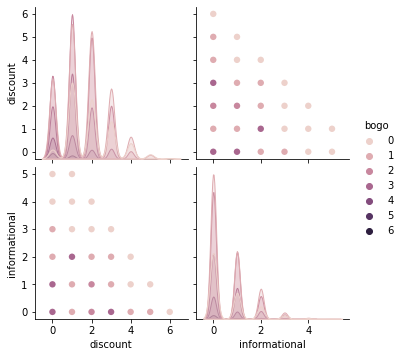

In [22]:
plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(offers_by_person, kind="scatter", hue="bogo", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

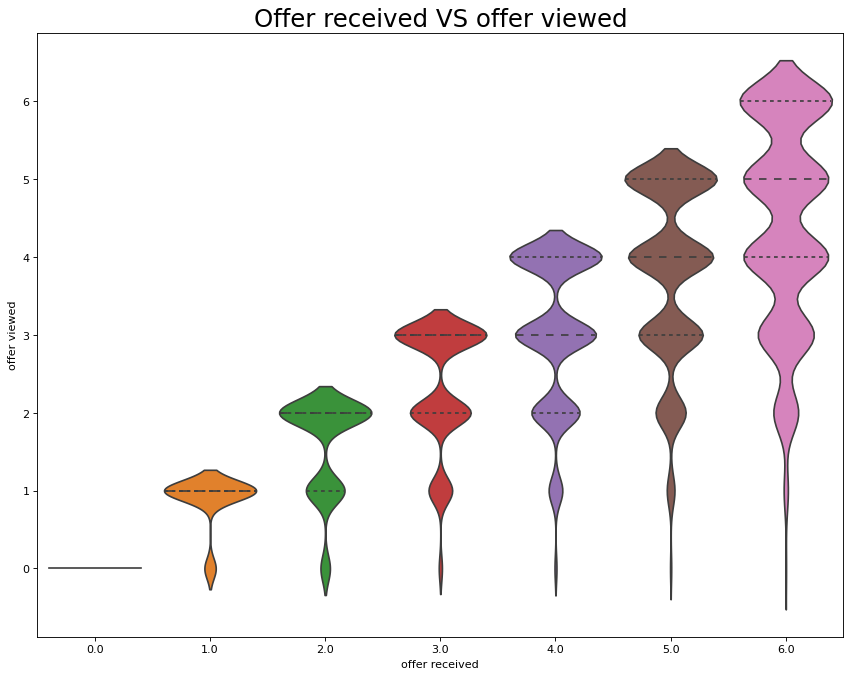

In [23]:
# Draw Plot
plt.figure(figsize=(13,10), dpi= 80)
sns.violinplot(x='offer received', y='offer viewed', data=event_count_dataset, scale='width', inner='quartile')

# Decoration
plt.title('Offer received VS offer viewed', fontsize=22)
plt.show()

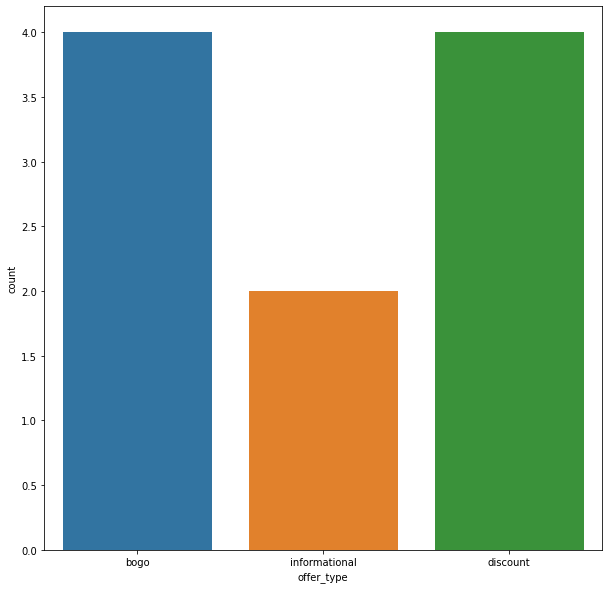

In [24]:
plt.figure(figsize=(10, 10))
sns.countplot(portfolio.offer_type);

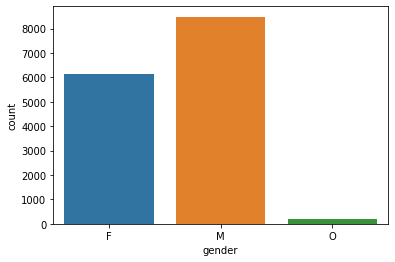

In [25]:
sns.countplot(profile.gender);

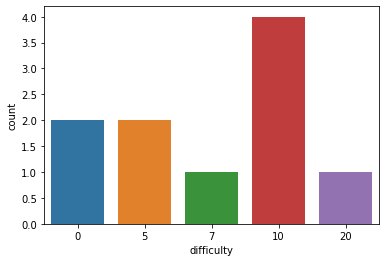

In [26]:
sns.countplot(portfolio.difficulty);

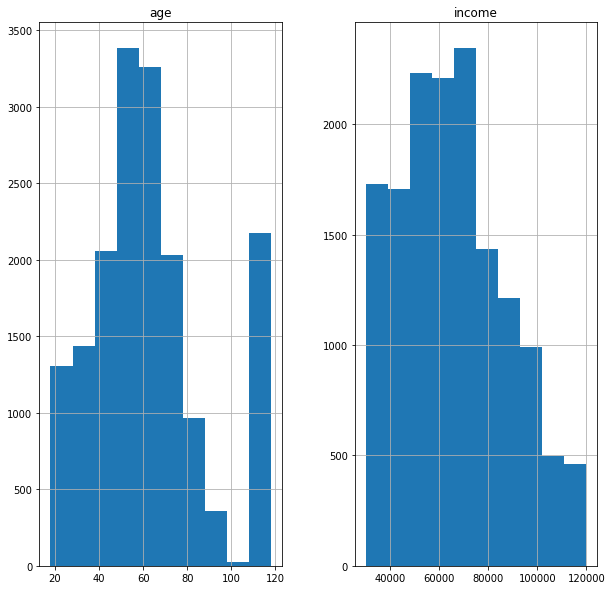

In [27]:
profile[['age', 'income']].hist(figsize=(10, 10));

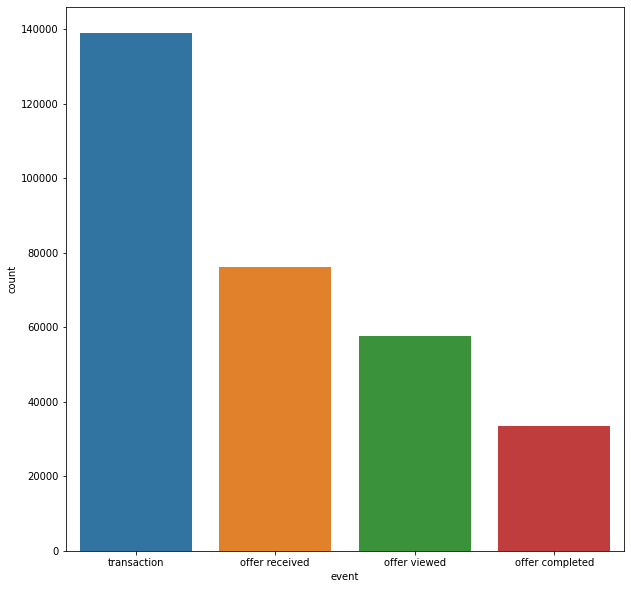

In [28]:
plt.figure(figsize=(10,10))
sns.countplot(transcript.event);

# STEP(7) --- Algorithms and Techniques

### We will prepare the data in a way that helps our model and its purpose.

In [29]:
def rename(dataset, new_name):
    dataset = dataset.rename(columns = new_name)
    return dataset

In [30]:
new_name = {'difficulty':'offer_difficulty' , 'id':'offer_id', 'duration':'offer_duration', 'reward': 'offer_reward'}
portfolio_cleanedup = rename(portfolio, new_name )

In [31]:
portfolio_cleanedup.head()

,offer_reward,channels,offer_difficulty,offer_duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [32]:
new_name = {'id':'customer_id' , 'income':'customer_income'}
profile_cleanedup = rename(profile, new_name)

In [33]:
profile_cleanedup.head()

,gender,age,customer_id,became_member_on,customer_income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


### We can see that they replace the missing age with 118 so we will replace it with Nan and then we can replace it with the mean value.
### Also we will replace missing income with the mean income.
### We can see some missing gender too so will replace it with the mode.
### We will add age group columns.

In [34]:
def clean_profile(dataset):
    dataset.replace(118, np.nan , inplace=True)
    dataset['age'] = dataset['age'].fillna(dataset['age'].mean())
    dataset['customer_income'] = dataset['customer_income'].fillna(dataset['customer_income'].mean())
    mode = dataset['gender'].mode()[0]
    dataset['gender'] = dataset['gender'].fillna(mode)

    dataset = dataset[dataset['age'] <= 90]
    dataset['age'] = dataset['age'].astype(int)
    
    
    dataset.loc[(dataset.age < 20) , 'Age_group'] = 'Under 20'
    dataset.loc[(dataset.age >= 20) & (dataset.age <= 40) , 'Age_group'] = '20-40'
    dataset.loc[(dataset.age >= 41) & (dataset.age <= 60) , 'Age_group'] = '41-60'
    dataset.loc[(dataset.age >= 61) , 'Age_group'] = '61-90'
    dataset.drop('age',axis=1,inplace=True)
    return dataset

In [35]:
profile_cleanedup = clean_profile(profile_cleanedup)

In [36]:
profile_cleanedup.tail()

,gender,customer_id,became_member_on,customer_income,Age_group
16995,F,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,41-60
16996,M,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,61-90
16997,M,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,41-60
16998,F,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,61-90
16999,F,e4052622e5ba45a8b96b59aba68cf068,20170722,82000.0,61-90


In [37]:
new_name = {'person':'customer_id'}
transcript_cleanedup = rename(transcript, new_name)

In [38]:
def clean_transcript(dataset):
    dataset['offer_id'] = dataset['value'].apply(lambda x: x.get('offer_id'))
    dataset['offer id'] = dataset['value'].apply(lambda x: x.get('offer id'))
    dataset['money_gained'] = dataset['value'].apply(lambda x: x.get('reward'))
    dataset['money_spent'] = dataset['value'].apply(lambda x: x.get('amount'))
    dataset['offer_id'] = dataset.apply(lambda x : x['offer id'] if x['offer_id'] == None else x['offer_id'], axis=1)
    dataset.drop(['offer id' , 'value'] , axis=1, inplace=True)
    dataset.fillna(0 , inplace=True)
    return dataset

In [39]:
transcript_cleanedup = clean_transcript(transcript_cleanedup)

In [40]:
transcript_cleanedup.tail()

,customer_id,event,time,offer_id,money_gained,money_spent
79667,ffff82501cea40309d5fdd7edcca4a07,transaction,198,0,0.0,22.88
32762,ffff82501cea40309d5fdd7edcca4a07,transaction,60,0,0.0,16.06
32763,ffff82501cea40309d5fdd7edcca4a07,offer completed,60,fafdcd668e3743c1bb461111dcafc2a4,2.0,0.00
112214,ffff82501cea40309d5fdd7edcca4a07,offer received,336,2906b810c7d4411798c6938adc9daaa5,0.0,0.00
143787,ffff82501cea40309d5fdd7edcca4a07,transaction,384,0,0.0,15.57


### Now we can merge all three datasets

In [41]:
def merge(portfolio,profile,transcript):
    merged_dataset = pd.merge(portfolio, transcript, on='offer_id')
    merged_dataset = pd.merge(merged_dataset, profile, on='customer_id')
    return merged_dataset

In [42]:
merged_dataset = merge(portfolio_cleanedup, profile_cleanedup, transcript_cleanedup)

In [43]:
merged_dataset.tail()

,offer_reward,channels,offer_difficulty,offer_duration,offer_type,offer_id,customer_id,event,time,money_gained,money_spent,gender,became_member_on,customer_income,Age_group
165315,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,e63e42480aae4ede9f07cac49c8c3f78,offer received,576,0.0,0.0,F,20161102,79000.000000,61-90
165316,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,f0aba2cbde6042bf8b46ed5478aa724b,offer received,408,0.0,0.0,M,20170115,65404.991568,41-60
165317,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,f0aba2cbde6042bf8b46ed5478aa724b,offer viewed,438,0.0,0.0,M,20170115,65404.991568,41-60
165318,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,fccc9279ba56411f80ffe8ce7e0935cd,offer viewed,534,0.0,0.0,F,20180425,94000.000000,61-90
165319,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,fccc9279ba56411f80ffe8ce7e0935cd,offer received,504,0.0,0.0,F,20180425,94000.000000,61-90


In [44]:
merged_dataset.drop('became_member_on',axis=1, inplace=True)   
merged_dataset.drop('customer_id',axis=1, inplace=True)   

### We will do final cleaning by changing cateogrical variables and normalize all the dataset

# STEP(8) --- Data Preprocessing

In [45]:
def final_clean(dataset):
    categorical = ['offer_type', 'gender', 'Age_group']
    dataset = pd.get_dummies(dataset, columns = categorical)
    dataset = dataset.drop('channels', 1).join(dataset.channels.str.join('|').str.get_dummies())


    offerids = dataset['offer_id'].unique().tolist()
    o_mapping = dict( zip(offerids,range(len(offerids))) )
    dataset.replace({'offer_id': o_mapping},inplace=True)

    #initialize a MinMaxScaler, then apply it to the features
    scaler = MinMaxScaler() 
    numerical = ['customer_income', 'offer_difficulty', 'offer_duration', 'offer_reward', 'time', 'money_gained', 'money_spent']
    dataset[numerical] = scaler.fit_transform(dataset[numerical])
    
    #encode 'event' data to numerical values according to task 2
    dataset['event'] = dataset['event'].map({'offer received':1, 'offer viewed':2, 'offer completed':3})
    
    return dataset


In [46]:
cleaned_data = final_clean(merged_dataset)

In [47]:
cleaned_data.tail(7)

,offer_reward,offer_difficulty,offer_duration,offer_id,event,time,money_gained,money_spent,customer_income,offer_type_bogo,...,gender_M,gender_O,Age_group_20-40,Age_group_41-60,Age_group_61-90,Age_group_Under 20,email,mobile,social,web
165313,0.2,0.5,0.571429,6,3,0.260504,0.2,0.0,0.222222,0,...,0,1,0,0,1,0,1,1,0,1
165314,0.2,0.5,0.571429,6,1,0.571429,0.0,0.0,0.544444,0,...,0,0,0,0,1,0,1,1,0,1
165315,0.2,0.5,0.571429,6,1,0.806723,0.0,0.0,0.544444,0,...,0,0,0,0,1,0,1,1,0,1
165316,0.2,0.5,0.571429,6,1,0.571429,0.0,0.0,0.393389,0,...,1,0,0,1,0,0,1,1,0,1
165317,0.2,0.5,0.571429,6,2,0.613445,0.0,0.0,0.393389,0,...,1,0,0,1,0,0,1,1,0,1
165318,0.2,0.5,0.571429,6,2,0.747899,0.0,0.0,0.711111,0,...,0,0,0,0,1,0,1,1,0,1
165319,0.2,0.5,0.571429,6,1,0.705882,0.0,0.0,0.711111,0,...,0,0,0,0,1,0,1,1,0,1


In [48]:
cleaned_data.event.value_counts()

1    75278
2    56986
3    33056
Name: event, dtype: int64

In [49]:
features = cleaned_data.drop('event', axis=1)
target = cleaned_data['event']

### Now our Dataset is ready for our Machine Learning Model

# STEP(9) --- Implementation and Metrics

### We will use the F1 score as the model metric to assess the quality of the approach and determine which model gives the best results. It is the weighted average of the precision and recall. 

In [50]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.25, random_state = 71)

print("Training set: {} rows".format(X_train.shape[0]))
print("Testing set: {} rows".format(X_test.shape[0]))

Training set: 123990 rows
Testing set: 41330 rows


### Return train and test F1 score along with the model name,   
### train_f1: train data F1 score
### test_f1: test data F1 score
###  name: model name
       

In [51]:
def training_testing(classifier):

    train_prediction =  (classifier.fit(X_train, y_train)).predict(X_train)
    test_predictions = (classifier.fit(X_train, y_train)).predict(X_test)
    train_f1 =  accuracy_score(y_train, train_prediction)*100
    test_f1= fbeta_score(y_test, test_predictions, beta = 0.5, average='micro' )*100
    name = classifier.__class__.__name__
    
    return train_f1, test_f1, name

# STEP(10) --- Get our benchmark model 

## Now we will test a naive classifier as our base Model

In [52]:
classifier_A = GaussianNB() 
a_train_f1, a_test_f1, a_model = training_testing(classifier_A)

In [53]:
naive_classifier = {'Benchmark Model': [ a_model], 'train F1 score':[a_train_f1], 'test F1 score': [a_test_f1]}
Benchmark_classifier = pd.DataFrame(naive_classifier)


In [54]:
Benchmark_classifier

,Benchmark Model,train F1 score,test F1 score
0,GaussianNB,62.440519,62.017905


# STEP(11) --- Model Evaluation and Validation

### We get here 62 % for our benchmark naive so we need to do better for our model

In [55]:
classifier_Z = DecisionTreeClassifier(random_state = 71)
z_train_f1, z_test_f1, z_model = training_testing(classifier_Z)

In [56]:
Decisiontree_classifier = {'Benchmark Model': [ z_model], 'train F1 score':[z_train_f1], 'test F1 score': [z_test_f1]}
Final_classifier = pd.DataFrame(Decisiontree_classifier)

In [57]:
Final_classifier

,Benchmark Model,train F1 score,test F1 score
0,DecisionTreeClassifier,92.782482,90.462134


# STEP(12) --- Justification (Conculusion)

### The test dataset is used to evaluate the model. Our model is better than the benchmark. The score is created by the DecisionTreeClassifier model, as its validate F1 score is 90.46, which is much higher than the benchmark. Our problem to solve is not that sensitive which requires very high F1 score, so the scores are good & sufficient and can be used for the classification purpose to predict whether a customer will respond to an offer.